# Mini Project 5 - Neural Network


## Import libraries

We will be using the lower resolution MINST data set

In [1]:
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 
import math

## Looking at the data

After we load the data, we print the shape of the data and a pixelated digit.

We also show what the features of one example looks like.

The neural net will learn to estimate which digit these pixels represent.

The shape of the digits dataset:
(1797, 64)


<Figure size 432x288 with 0 Axes>

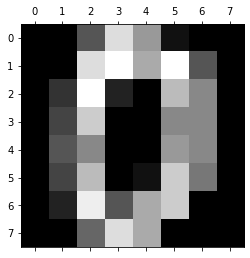

[0]
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [2]:
# load all the digits (img)
digits = load_digits()
# load the data from the digit (img)
X = digits.data
y = digits.target
print("The shape of the digits dataset:") 
print(X.shape)

# plot the digits
# using .gray()
plt.gray()
# and .matshow() with argument digit.images[xx]
plt.matshow(digits.images[0])
# plt.show()
plt.show()
# get the gt for this digit img
print(y[0:1])
print(X[0,:])

## 1) Scale the dataset
The training features range from 0 to 15.  To help the algorithm converge, we will scale the data to have a mean of 0 and unit variance

In [3]:
# use the stander lib to scale the data
# init the scaler 
scaler = StandardScaler()
# fit the data to the scaler 
scaler.fit(X)
X = scaler.transform(X)

# Looking the new features after scaling
print(X[0,:])
print(X.shape)

[ 0.         -0.33501649 -0.04308102  0.27407152 -0.66447751 -0.84412939
 -0.40972392 -0.12502292 -0.05907756 -0.62400926  0.4829745   0.75962245
 -0.05842586  1.12772113  0.87958306 -0.13043338 -0.04462507  0.11144272
  0.89588044 -0.86066632 -1.14964846  0.51547187  1.90596347 -0.11422184
 -0.03337973  0.48648928  0.46988512 -1.49990136 -1.61406277  0.07639777
  1.54181413 -0.04723238  0.          0.76465553  0.05263019 -1.44763006
 -1.73666443  0.04361588  1.43955804  0.         -0.06134367  0.8105536
  0.63011714 -1.12245711 -1.06623158  0.66096475  0.81845076 -0.08874162
 -0.03543326  0.74211893  1.15065212 -0.86867056  0.11012973  0.53761116
 -0.75743581 -0.20978513 -0.02359646 -0.29908135  0.08671869  0.20829258
 -0.36677122 -1.14664746 -0.5056698  -0.19600752]
(1797, 64)


## 2) Creating training and test datasets
We split the data into training and test data sets. We will train the neural network with the training dataset, and evaluate our neural network with the test dataset 

In [4]:
#Split the data into training and test set.  60% training and %40 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, train_size = 0.6)
print(y_train.shape, y_test.shape)

(1078,) (719,)


## 3) Setting up the output layer

### One hot encoding

In [5]:
def convert_y_to_vect(y):
#     Our target is an integer in the range [0,..,9], so we will have 10 output neuron's in our network.  

#     If  y=0 we want the output neurons to have the values (1,0,0,0,0,0,0,0,0,0)
#     If  y=1 we want the output neurons to have the values (0,1,0,0,0,0,0,0,0,0)
#     etc

#     Thus we need to change our target so it is the same as our hoped for output of the neural network. 

#     If y=0$we change it into the vector (1,0,0,0,0,0,0,0,0,0)
#     If y=1 we change it into the vector (0,1,0,0,0,0,0,0,0,0)
#     etc

#     The code to covert the target vector. 
    num_samples = y.shape[0]
    result = np.zeros((num_samples, 10))
    for i in range(num_samples):
      result[i][y[i]] = 1
    return result
    
print(convert_y_to_vect(y))

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


Converting the training and test targets to vectors 

In [6]:
# convert digits to vectors using the func above

# apply this to both train and test splits
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

A quick check to see that our code performs as we expect 

In [7]:
print(y_train[0:4])
print(y_v_train[0:4])

[5 6 3 7]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


## 4) Creating the neural network

### The activation function and its derivative

In [8]:
# We will use the sigmoid activation function:  f(z)={1}/{1+e^{-z}}
def f(z):
    return 1/(1+math.exp(-z))

# The deriviative of the sigmoid function is: $f'(z) = f(z)(1-f(z))$ 
def f_deriv(z):
    return f(z)*(1-f(z))

### Creating and initialing W and b




In [9]:
from random import random
def setup_and_init_weights(nn_structure):
    # The weights in W are different so that during back propagation the nodes on a level will have different gradients and thus have different update values.
    #creating a dictionary for weights i.e. a set of key: value pairs
    w_dict = {}
    #creating a dictionary for bias i.e. a set of key: value pairs
    b_dict = {}
    for j in range(1, len(nn_structure)):
      w_dict[j] = np.array([[random() for i in range(nn_structure[j-1])] for i in range(nn_structure[j])])
      b_dict[j] = np.array([random() for i in range(nn_structure[j])]).reshape(nn_structure[j],1)

    # Return weight and b
    return w_dict, b_dict

### Initializing $\triangledown W$ and $\triangledown b$


In [10]:
def init_tri_values(nn_structure):
    # Creating dlt_W and dlt_b to have the same size as W and b,and init the dlt_W, and dlt_b to 0
    # use for loop to init the dlt W and dlt b, using np.zeros
    dlt_w = {}
    dlt_b = {}
    for j in range(1, len(nn_structure)):
      dlt_w[j] = np.zeros((nn_structure[j], nn_structure[j-1]))
      dlt_b[j] = np.zeros((nn_structure[j],1))
    return dlt_w, dlt_b

## Feed forward
Perform a forward pass throught the network.  The function returns the values of $a$ and $z$

In [11]:
from re import A
def feed_forward(x, W, b):
    # create a dictionary for holding the a values for all levels
    a = {}
    a = {1: np.array(x)}
    # create a dictionary for holding the z values for all the layers
    z = {}
    for l in range(2,len(W) + 2):
      a[l] = np.zeros(W[l-1].shape[0])
      z[l] = np.zeros(W[l-1].shape[0])
    # for each layer
    for l in range(1, len(W)+1):
      # z^(l+1) = W^(l)*a^(l) + b^(l)
      z[l+1] =  W[l] @ a[l][np.newaxis].T + b[l]
      # a^(l+1) = f(z^(l+1))
      a[l+1] = np.array([f(i) for i in z[l+1]])
    return a, z

## Compute $\delta$
compute $\delta^{(s_l)}$ in a function called "calculate_out_layer_delta",  and  computes $\delta^{(\ell)}$ for the hidden layers in the function called "calculate_hidden_delta".  



In [12]:
def calculate_out_layer_delta(y, a_out, z_out):
    #create a temporary array to store the values of f'(z^l),
    #since our function f_deriv(z^l) isn't designed to take in arrays as input
    temp = np.array([f_deriv(i) for i in z_out])

    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    delta = -(y - a_out) * temp
    return delta


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    #create a temporary array to store the values of f(z^l),
    #since our function f(z^l) isn't designed to take in arrays as input
    temp = np.array([f_deriv(i) for i in z_l])

    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    delta = w_l.T @ delta_plus_1[np.newaxis].T * temp[np.newaxis].T
    return delta

## The Back Propagation Algorithm


In [36]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.01):
    # init W and b
    W, b = setup_and_init_weights(nn_structure)
    # init counter to 0
    counter = 0
    # store the length of data
    N = y.shape[0]
    # init a list to store the all costs
    costs = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    # while the counter is less than the max iterations:
    while(counter < iter_num):
      # print the iteration number for every 100 iter
      if(counter % 100 == 0):
        print('Iteration', counter, 'of', iter_num)
      # init delt_W and delt_b
      delt_W, delt_b = init_tri_values(nn_structure)
      # init the cost to 0
      cost = float(0)
      # for each data:
      for i in range(N):
          # perform the feed forward pass and return the stored a and z values, to be used in the
          # gradient descent step
          a,z = feed_forward(X[i], W, b)

          #init the dictionary to store the delta for each layer
          delts = {}

          # loop from nl-1 to 1 backpropagating the errors
          for l in range(len(nn_structure), 0, -1):

              if l == len(nn_structure):
                #calculate delta out
                delt_out = calculate_out_layer_delta(y[i], a[l], z[l])
                #calculate the cost
                cost += sum(np.argmax(a[l]) - np.where(y[i] == 1))**2
                
              # first layer
              elif l == len(nn_structure) - 1: 
                # delt_W^(l) = delt_W^(l) + delta^(l+1) * transpose(a^(l))
                delt_W[l] = delt_W[l] + delt_out[np.newaxis].T * a[l][np.newaxis]
                # delt_b^(l) = delt_b^(l) + delta^(l+1)
                delt_b[l] = delt_b[l] + delt_out[np.newaxis].T

                #add delt_out to the dictionary of deltas
                delts[l] = delt_out

              #all hidden layers
              else:
                #calculate delta hidden
                delt_hid = calculate_hidden_delta(delts[l+1], W[l + 1], z[l + 1])
                delts[l] = delt_hid.flatten()
                # delt_W^(l) = delt_W^(l) + delta^(l+1) * transpose(a^(l))
                delt_W[l] = delt_W[l] + delt_hid * a[l][np.newaxis]
                # delt_b^(l) = delt_b^(l) + delta^(l+1)
                delt_b[l] = delt_b[l] + delt_hid

                  # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    # hint: you can use np.newaxis to increase the number of dimensions
                  # trib^(l) = trib^(l) + delta^(l+1)
                
      
      # perform the gradient descent step for the weights in each layer
      for l in range(len(nn_structure)-1, 0, -1):
        W[l] = W[l] - alpha * delt_W[l]
        b[l] = b[l] - alpha * delt_b[l]

      # complete the average cost (mean squared error) calculation
      cost /= N
      # append the cost to the cost list
      costs.append(cost)
      # increase the counter 
      counter += 1

    return W, b, costs

In [37]:
def predict_y(W, b, X, n_layers):
    # store the length of data
    N = X.shape[0]
    # init for prediction array
    pred = np.empty(N)
    # for each data:
    for i in range(N):
        # feed forward
        a, z = feed_forward(X[i], W, b)
        # predict based on the output of the last layer
        pred[i] = np.argmax(a[n_layers])
    return pred

## Running the neural network

Our code assumes the size of each layer in our network is held in a list.  The input layer will have 64 neurons (one for each pixel in our 8 by 8 pixelated digit).  Our hidden layer has 30 neurons (you can change this value).  The output layer has 10 neurons.

Next we create the python list to hold the number of neurons for each level and then run the neural network code with our training data.

This code will take some time...

In [15]:
nn_structure = [64, 30, 10]
    
# train the NN with the nn_structure and 3000 iterations
W, b, costs = train_nn(nn_structure, X_train, y_v_train)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 100 of 3000
Iteration 200 of 3000
Iteration 300 of 3000
Iteration 400 of 3000
Iteration 500 of 3000
Iteration 600 of 3000
Iteration 700 of 3000
Iteration 800 of 3000
Iteration 900 of 3000
Iteration 1000 of 3000
Iteration 1100 of 3000
Iteration 1200 of 3000
Iteration 1300 of 3000
Iteration 1400 of 3000
Iteration 1500 of 3000
Iteration 1600 of 3000
Iteration 1700 of 3000
Iteration 1800 of 3000
Iteration 1900 of 3000
Iteration 2000 of 3000
Iteration 2100 of 3000
Iteration 2200 of 3000
Iteration 2300 of 3000
Iteration 2400 of 3000
Iteration 2500 of 3000
Iteration 2600 of 3000
Iteration 2700 of 3000
Iteration 2800 of 3000
Iteration 2900 of 3000


### Plotting the learning curve


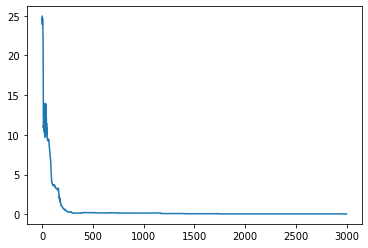

In [16]:
# plot the avg_cost_func 

# x label: "Iteration number"
# y label: "Average J"
plt.plot([i for i in range(3000)], costs)
plt.show()


## 5) Assessing accuracy
Next we determine what percentage the neural network correctly predicted the handwritten digit correctly on the test set

In [17]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 94.71488178025035%


As we can see, the neural network with structure [64, 30, 10] yields a pretty decent accuracy. Also, according to the graph, the cost curve converges roughly after 500 iterations.

## Try our model with different number of neurons in the hidden layer

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 100 of 3000
Iteration 200 of 3000
Iteration 300 of 3000
Iteration 400 of 3000
Iteration 500 of 3000
Iteration 600 of 3000
Iteration 700 of 3000
Iteration 800 of 3000
Iteration 900 of 3000
Iteration 1000 of 3000
Iteration 1100 of 3000
Iteration 1200 of 3000
Iteration 1300 of 3000
Iteration 1400 of 3000
Iteration 1500 of 3000
Iteration 1600 of 3000
Iteration 1700 of 3000
Iteration 1800 of 3000
Iteration 1900 of 3000
Iteration 2000 of 3000
Iteration 2100 of 3000
Iteration 2200 of 3000
Iteration 2300 of 3000
Iteration 2400 of 3000
Iteration 2500 of 3000
Iteration 2600 of 3000
Iteration 2700 of 3000
Iteration 2800 of 3000
Iteration 2900 of 3000


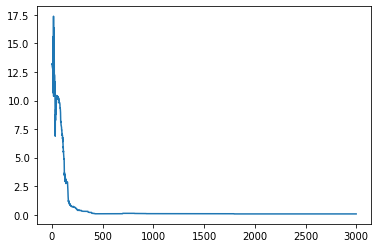

Prediction accuracy is 95.13212795549374%


In [ ]:
nn_structure = [64, 40, 10]

# train the NN with the nn_structure and 3000 iterations
W, b, costs = train_nn(nn_structure, X_train, y_v_train)

# plot the avg_cost_func 

# x label: "Iteration number"
# y label: "Average J"
plt.plot([i for i in range(3000)], costs)
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

As we can see, changing the number of neurons in our one hidden layer does not cause a significant change in either accurracy or performance. The cost curve fluctuates but also converges roughly after 500 iterations

## Try our model with 4 layers instead of 3

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 100 of 3000
Iteration 200 of 3000
Iteration 300 of 3000
Iteration 400 of 3000
Iteration 500 of 3000
Iteration 600 of 3000
Iteration 700 of 3000
Iteration 800 of 3000
Iteration 900 of 3000
Iteration 1000 of 3000
Iteration 1100 of 3000
Iteration 1200 of 3000
Iteration 1300 of 3000
Iteration 1400 of 3000
Iteration 1500 of 3000
Iteration 1600 of 3000
Iteration 1700 of 3000
Iteration 1800 of 3000
Iteration 1900 of 3000
Iteration 2000 of 3000
Iteration 2100 of 3000
Iteration 2200 of 3000
Iteration 2300 of 3000
Iteration 2400 of 3000
Iteration 2500 of 3000
Iteration 2600 of 3000
Iteration 2700 of 3000
Iteration 2800 of 3000
Iteration 2900 of 3000


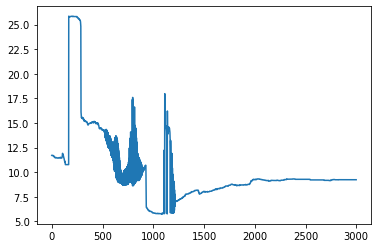

Prediction accuracy is 9.735744089012517%


In [ ]:
nn_structure = [64, 40, 20, 10]

# train the NN with the nn_structure and 3000 iterations
W, b, costs = train_nn(nn_structure, X_train, y_v_train)

# plot the avg_cost_func 

# x label: "Iteration number"
# y label: "Average J"
plt.plot([i for i in range(3000)], costs)
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

As we can see, adding another hidden layer causes huge fluctuations in cost function and its performance drops significantly. The cost function converges at after 2500 iterations and the prediction accuracy is really low.

The f(z) function is designed to only take in single values, which is also the design in my other test examples of different activation functions. However, this error doesn't occur all in my other test examples and therefore I have no idea how to debug it. 

Therefore, I put in 'return max(0,z.all())' to avoid runtime error, which results in update failure during training.


## Test our function with tanh activation function:
$$ f(z) = tanh(z) = \frac {e^z - e^{-z}}{e^z + e^{-z}}$$
$$ f'(z) = 1 - tanh^2z = 1 - f(z)^2$$

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 100 of 3000
Iteration 200 of 3000
Iteration 300 of 3000
Iteration 400 of 3000
Iteration 500 of 3000
Iteration 600 of 3000
Iteration 700 of 3000
Iteration 800 of 3000
Iteration 900 of 3000
Iteration 1000 of 3000
Iteration 1100 of 3000
Iteration 1200 of 3000
Iteration 1300 of 3000
Iteration 1400 of 3000
Iteration 1500 of 3000
Iteration 1600 of 3000
Iteration 1700 of 3000
Iteration 1800 of 3000
Iteration 1900 of 3000
Iteration 2000 of 3000
Iteration 2100 of 3000
Iteration 2200 of 3000
Iteration 2300 of 3000
Iteration 2400 of 3000
Iteration 2500 of 3000
Iteration 2600 of 3000
Iteration 2700 of 3000
Iteration 2800 of 3000
Iteration 2900 of 3000


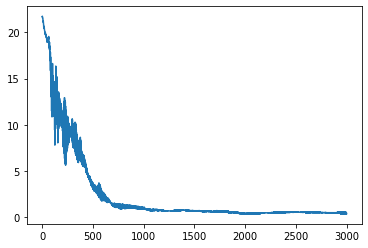

Prediction accuracy is 91.3769123783032%


In [43]:
#redefine our activation function to tanh activation function: f(z) = {0 if z < 0, z if z > 0}
def f(z):
  return (math.exp(z) - math.exp(-z))/(math.exp(z) + math.exp(-z))

#f'(z) = 1 - f(z)^2
def f_deriv(z):
  return 1 - f(z)**2


nn_structure = [64, 30, 10]

# train the NN with the nn_structure and 3000 iterations
W, b, costs = train_nn(nn_structure, X_train, y_v_train, alpha=0.001)

# plot the avg_cost_func 

# x label: "Iteration number"
# y label: "Average J"v
plt.plot([i for i in range(3000)], costs)
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

The neural network with tanh activation has more fluctuation compared to sigmoid function, and it takes more iterations to converge. In the end the accuracy of this model isn't the optimal, but not bad either.

### Conclusion:
According to the neural network we tested, the three-layer sigmoid activated neural network has the best performance. However, this does not mean that other models are inferior, because here we only present the result with certain parameters. Different models may have different performance in their optimized parameters, which is not fully shown in here.